In [1]:
# Read data
import pandas as pd
data = pd.read_csv("Final_data.csv")
print(data.head(5))
print(data.dtypes)
# print(data.isna().sum()) # there is no nan in the dataset

     Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0  34.91    Male        65.27        1.62   188.58   157.65        69.05   
1  23.37  Female        56.41        1.55   179.43   131.75        73.18   
2  33.20  Female        58.98        1.67   175.04   123.95        54.96   
3  38.69  Female        93.78        1.70   191.21   155.10        50.07   
4  45.09    Male        52.42        1.88   193.58   152.88        70.84   

   Session_Duration (hours)  Calories_Burned Workout_Type  ...  \
0                      1.00          1080.90     Strength  ...   
1                      1.37          1809.91         HIIT  ...   
2                      0.91           802.26       Cardio  ...   
3                      1.10          1450.79         HIIT  ...   
4                      1.08          1166.40     Strength  ...   

   cal_from_macros  pct_carbs  protein_per_kg   pct_HRR  pct_maxHR  \
0          2139.59   0.500432        1.624789  0.741237   0.835985   
1     

In [2]:
# Define X and y
y_tree = data["Calories_Burned"] 

predictors = [
    # 1. Demographics
    "Age", "Gender", "Height (m)", "Weight (kg)",

    # 2. Heart Rate Metrics
    "Resting_BPM", "Avg_BPM", "Max_BPM",

    # 3. Exercise & Training
    "Workout_Type", "Session_Duration (hours)",
    "Workout_Frequency (days/week)",
    "Experience_Level", "Difficulty Level",

    # 4. Body Composition
    "BMI", "Fat_Percentage", "lean_mass_kg",

    # 5. Nutrition
    "Calories", "Carbs", "Proteins", "Fats",
    "Water_Intake (liters)",

    # 6. Meal details
    "meal_name", "meal_type", "diet_type",
    "sugar_g", "sodium_mg", "cholesterol_mg",

    # 7. Derived Features
    "pct_maxHR", "cal_balance", "protein_per_kg", "BMI_calc",
]

X_tree = data[predictors]
# Encode categorical variable
X_tree = pd.get_dummies(X_tree, drop_first=True)

y_tree.describe()

count    20000.000000
mean      1280.109600
std        502.228982
min        323.110000
25%        910.800000
50%       1231.450000
75%       1553.112500
max       2890.820000
Name: Calories_Burned, dtype: float64

# XG boosting

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


X_train, X_test, y_train, y_test = train_test_split(
    X_tree, y_tree, test_size=0.2, random_state=42)

from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# 4. Predict & evaluate
y_pred_xg = xgb_model.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, y_pred_xg))
print("Test RMSE:", mean_squared_error(y_test, y_pred_xg, squared=False))
print("Test R²:", r2_score(y_test, y_pred_xg)) #overfitting?

y_pred_train_xg = xgb_model.predict(X_train)

print("Train MAE:", mean_absolute_error(y_train, y_pred_train_xg))
print("Train RMSE:", mean_squared_error(y_train, y_pred_train_xg, squared=False))
print("Train R²:", r2_score(y_train, y_pred_train_xg))

Test MAE: 4.79601781036377
Test RMSE: 6.342982053587949
Test R²: 0.9998386681117661
Train MAE: 4.60180841911316
Train RMSE: 6.071481422439574
Train R²: 0.9998542565714196


/Users/centracy/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/centracy/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/Users/centracy/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


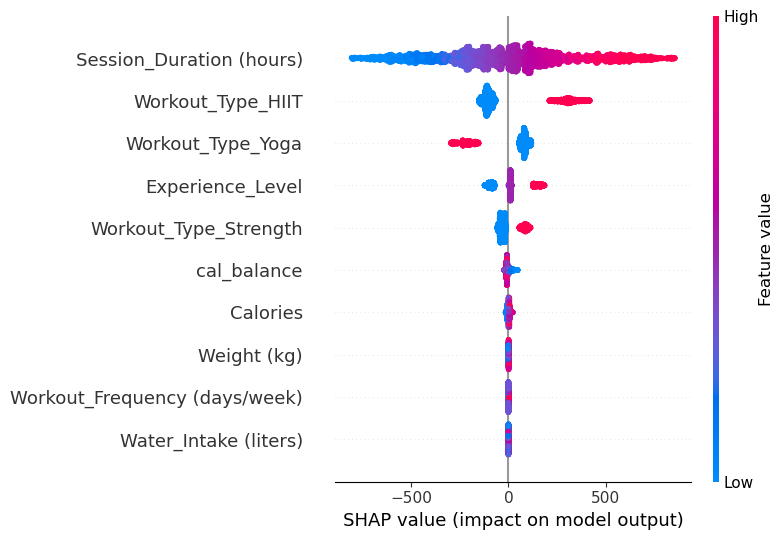

In [4]:
# SHAP graph
import shap
import numpy as np


explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Compute mean absolute SHAP per feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Get the indices of the top 10
top10_idx = np.argsort(mean_abs_shap)[-10:]

# Sort them so the plot is clean
top10_idx = top10_idx[np.argsort(mean_abs_shap[top10_idx])]

# Plot only top 10
shap.summary_plot(shap_values[:, top10_idx], 
                  X_test.iloc[:, top10_idx], 
                  feature_names=X_test.columns[top10_idx])